**Topic: Exploratory Data Analysis on Non-rectangular Data**

**Rectangular Data Structures**
The typical frame of reference for an analysis in data science is a rectangular data object, like a spreadsheet or database table.
Rectangular data is essentially a two-dimensional matrix with rows indicating records and columns indicating features

**Nonrectangular Data Structures**
There are other data structures besides rectangular data.
Time series data records successive measurements of the same variable. It is the raw material for statistical forecasting methods, and it is also a key component of the data produced by devices—the Internet of Things.

**What is Time Series?**
A time series is a set of observation taken at specified times usually at equal intervals
It is used to predict the future values based on the previous observed values

**Example 1**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from datetime import datetime
import seaborn as sns
rcParams['figure.figsize']=10,6

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')




Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
Location="/content/gdrive/MyDrive/FDS_PRAC/datasets/FDSJOURNAL_DATASETS/AirPassengers.csv"
dataset=pd.read_csv(Location)


### **Data Exploration**



In [ ]:
#Parse strings to datetime type
dataset['Month']=pd.to_datetime(dataset['Month'], infer_datetime_format=True)
dataset.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [ ]:
indexedDataset = dataset.set_index('Month')  
indexedDataset.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [ ]:
indexedDataset.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
indexedDataset.tail() 

,Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [ ]:
indexedDataset.size

144

In [ ]:
indexedDataset.dtypes

Passengers    int64
dtype: object

In [ ]:
indexedDataset.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [ ]:
#Checking for null values
indexedDataset.isnull().sum()

Passengers    0
dtype: int64

In [ ]:
indexedDataset.columns

Index(['Passengers'], dtype='object')

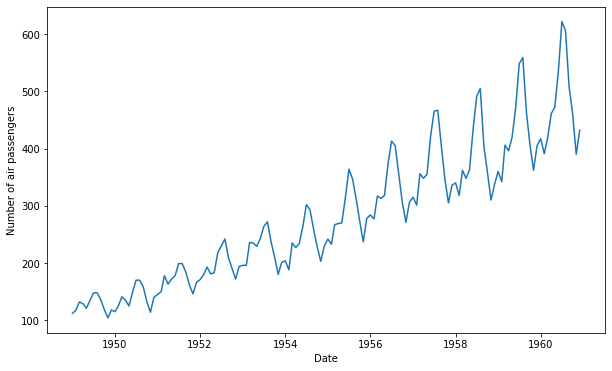

In [ ]:
#Plot Graph
plt.xlabel("Date")
plt.ylabel("Number of air passengers")
plt.plot(indexedDataset)

## **Checking for Stationarity**

In [ ]:
rollmean=indexedDataset.rolling(window=12).mean()

rollstd=indexedDataset.rolling(window=12).std()
print(rollmean,rollstd)

            Passengers
Month                 
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
...                ...
1960-08-01  463.333333
1960-09-01  467.083333
1960-10-01  471.583333
1960-11-01  473.916667
1960-12-01  476.166667

[144 rows x 1 columns]             Passengers
Month                 
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
...                ...
1960-08-01   83.630500
1960-09-01   84.617276
1960-10-01   82.541954
1960-11-01   79.502382
1960-12-01   77.737125

[144 rows x 1 columns]


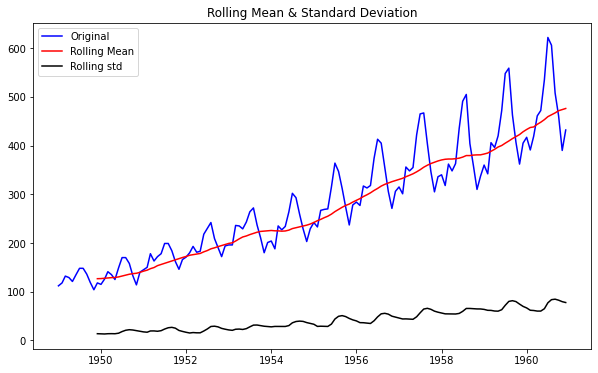

In [ ]:
#Plot rolling statistics
orig=plt.plot(indexedDataset, color='blue', label='Original')
mean=plt.plot(rollmean, color='red', label='Rolling Mean')
std=plt.plot(rollstd, color='black', label='Rolling std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
#Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller

print ('Results of Dickey-Fuller Test:')
dftest = adfuller(indexedDataset['Passengers'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


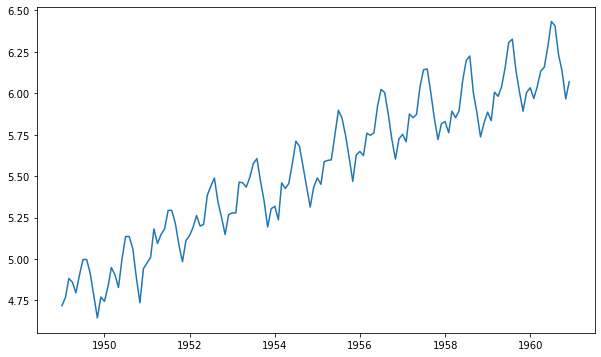

In [ ]:
# Estimating trend
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

# **Smoothing: Moving Average**

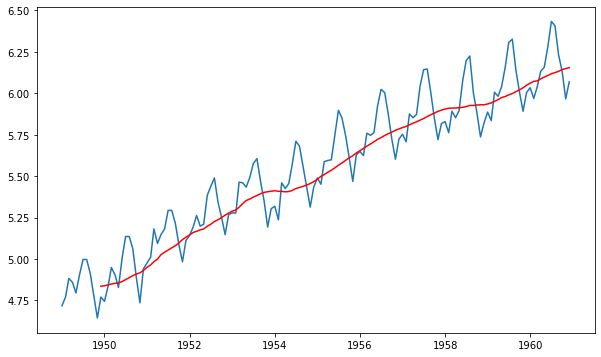

In [ ]:
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [ ]:
# Get the difference between the moving average and the actual number of passengers
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)
#Remove Nan Values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
1950-05-01,-0.027529
1950-06-01,0.139881
1950-07-01,0.260184
1950-08-01,0.248635


In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

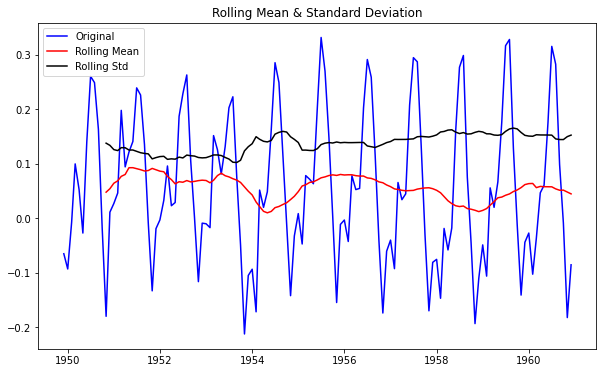

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [ ]:
test_stationarity(datasetLogScaleMinusMovingAverage)

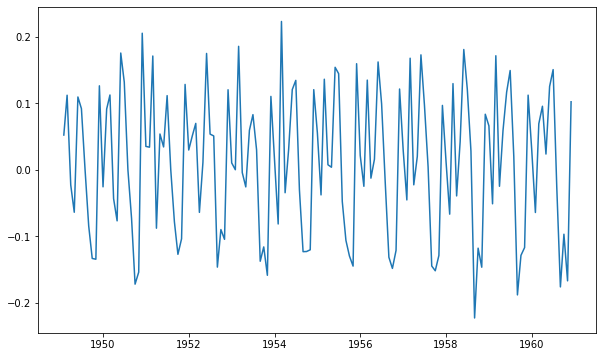

In [ ]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

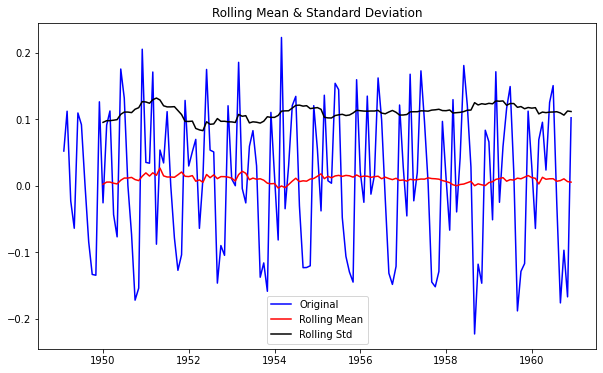

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [ ]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

# **Decomposition of a time series data into its components: trend, seasonality, and noise.**

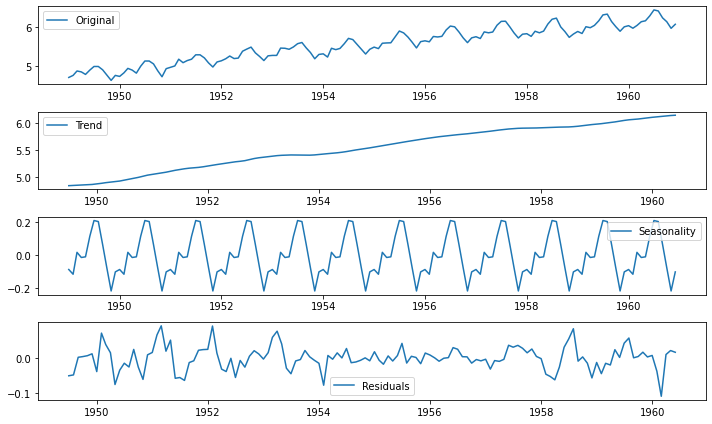

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexedDataset_logScale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


**Example 2**

# **Exploratory Data Analysis-Rectangular Data**

In [ ]:
#installations

In [ ]:
pip install wquantiles


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import required Python packages.

In [ ]:
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
from scipy.stats import trim_mean
from statsmodels import robust
import wquantiles
import seaborn as sns
import matplotlib.pylab as plt


mounting

In [ ]:
#Mounting Google Drive
#issue with the cardio_train dataset
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
Location = "/content/gdrive/MyDrive/FDS_PRAC/datasets/FDSJOURNAL_DATASETS/cardio_train.csv"
df = pd.read_csv(Location)
df.head()


,id;age;gender;height;weight;ap_hi;ap_lo;cholesterol;gluc;smoke;alco;active;cardio
0,0;18393;2;168;62.0;110;80;1;1;0;0;1;0
1,1;20228;1;156;85.0;140;90;3;1;0;0;1;1
2,2;18857;1;165;64.0;130;70;3;1;0;0;0;1
3,3;17623;2;169;82.0;150;100;1;1;0;0;1;1
4,4;17474;1;156;56.0;100;60;1;1;0;0;0;0


#Estimates of Height and weight

Compute the mean, trimmed mean, and median for Height & Wieght. For mean and median we can use the pandas methods of the data frame. The trimmed mean requires the trim_mean function in scipy.stats.

In [ ]:
print(df['height'].mean())

164.0126939351199


In [ ]:
print(trim_mean(df['height'], 0.1))

163.95957820738138


In [ ]:
print(df['height'].median())

164.0


In [ ]:
print(df['weight'].mean())

74.42919605077574


In [ ]:
print(np.average(df['weight'], weights=df['height']))

74.71242378638689


Weighted mean is available with numpy. For weighted median, we can use the specialised package wquantiles

In [ ]:
print(wquantiles.median(df['weight'], weights=df['height']))

72.0


#Estimates of Variability

Standard deviation

In [ ]:
print(df['height'].std())

8.633210556457215



Interquartile range is calculated as the difference of the 75% and 25% quantile.

In [ ]:
print(df['height'].quantile(0.75) - df['height'].quantile(0.25))

12.0


Median absolute deviation from the median can be calculated with a method in statsmodels

In [ ]:
print(robust.scale.mad(df['height']))
print(abs(df['height'] - df['height'].median()).median() / 0.6744897501960817)

8.895613311033612
8.895613311033612


#Percentiles and Boxplots
Pandas has the quantile method for data frames.

In [ ]:
print(df['weight'].quantile([0.05, 0.25, 0.5, 0.75, 0.95]))

0.05     54.0
0.25     64.0
0.50     72.0
0.75     84.0
0.95    100.0
Name: weight, dtype: float64


In [ ]:
percentages = [0.05, 0.25, 0.5, 0.75, 0.95]
df1 = pd.DataFrame(df['weight'].quantile(percentages))
df1.index = [f'{p * 100}%' for p in percentages]
print(df.transpose())

                 0        1        2    ...      706      707      708
Id               0.0      1.0      2.0  ...    997.0    999.0   1000.0
age          18393.0  20228.0  18857.0  ...  22547.0  21250.0  22446.0
gender           2.0      1.0      1.0  ...      1.0      1.0      1.0
height         168.0    156.0    165.0  ...    161.0    157.0    158.0
weight          62.0     85.0     64.0  ...     93.0     68.0     65.0
ap_hi          110.0    140.0    130.0  ...    140.0    110.0    140.0
ap_lo           80.0     90.0     70.0  ...     90.0     80.0     90.0
cholesterol      1.0      3.0      3.0  ...      2.0      1.0      3.0
gluc             1.0      1.0      1.0  ...      1.0      1.0      1.0
smoke            0.0      0.0      0.0  ...      0.0      0.0      0.0
alco             0.0      0.0      0.0  ...      0.0      0.0      0.0
active           1.0      1.0      0.0  ...      1.0      1.0      1.0
cardio           0.0      1.0      1.0  ...      1.0      0.0      1.0

[13 r

Pandas provides a number of basic exploratory plots; one of them are boxplots

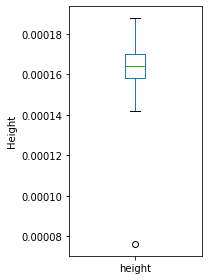

In [ ]:
ax = (df['height']/1_000_000).plot.box(figsize=(3, 4))
ax.set_ylabel('Height')

plt.tight_layout()
plt.show()

#Frequency Table and Histograms
The cut method for pandas data splits the dataset into bins. There are a number of arguments for the method. The following code creates equal sized bins. The method value_counts returns a frequency table.

In [ ]:
binnedHeight = pd.cut(df['height'], 10)
print(binnedHeight.value_counts())

(154.4, 165.6]    343
(165.6, 176.8]    245
(143.2, 154.4]     75
(176.8, 188.0]     44
(132.0, 143.2]      1
(75.888, 87.2]      1
(120.8, 132.0]      0
(109.6, 120.8]      0
(98.4, 109.6]       0
(87.2, 98.4]        0
Name: height, dtype: int64


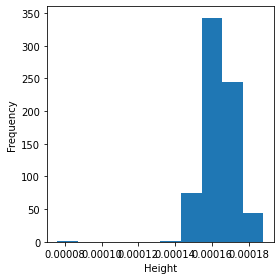

In [ ]:
ax = (df['height'] / 1_000_000).plot.hist(figsize=(4, 4))
ax.set_xlabel('Height')

plt.tight_layout()
plt.show()

#Density Estimates
Density is an alternative to histograms that can provide more insight into the distribution of the data points. Use the argument bw_method to control the smoothness of the density curve.

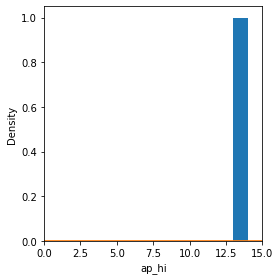

In [ ]:
ax = df['ap_hi'].plot.hist(density=True, xlim=[0, 15], 
                                    bins=range(1,15), figsize=(4, 4))
df['ap_hi'].plot.density(ax=ax)
ax.set_xlabel('ap_hi')

plt.tight_layout()
plt.show()

In [ ]:
dfn1 = df[['height','weight']]
dfn1.head()

,height,weight
0,168,62.0
1,156,85.0
2,165,64.0
3,169,82.0
4,156,56.0


In [ ]:
dfn2 = df[['ap_hi','ap_lo']]
dfn2.head()

,ap_hi,ap_lo
0,110,80
1,140,90
2,130,70
3,150,100
4,100,60


#Exploring Binary and Categorical Data

In [ ]:
print(100 * dfn1 / dfn1.values.sum())

       height    weight
0    0.099376  0.036674
1    0.092277  0.050279
2    0.097601  0.037857
3    0.099967  0.048505
4    0.092277  0.033125
..        ...       ...
704  0.097010  0.036083
705  0.095827  0.042590
706  0.095235  0.055012
707  0.092869  0.040224
708  0.093461  0.038449

[709 rows x 2 columns]


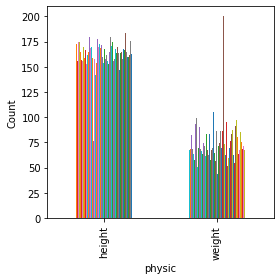

In [ ]:
ax = dfn1.transpose().plot.bar(figsize=(4, 4), legend=False)
ax.set_xlabel('physic')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

#Correlation
correlation matrix

In [ ]:
data=df.corr()
print(data)

                   Id       age    gender  ...      alco    active    cardio
Id           1.000000 -0.026904 -0.071267  ...  0.021380  0.016990 -0.036547
age         -0.026904  1.000000  0.001430  ... -0.074528 -0.007464  0.236791
gender      -0.071267  0.001430  1.000000  ...  0.175032 -0.032629 -0.038012
height      -0.043734 -0.106335  0.469850  ...  0.120415 -0.064885  0.010605
weight       0.034737 -0.016563  0.136394  ...  0.058611 -0.047885  0.144348
ap_hi       -0.021004  0.179657  0.052524  ...  0.022570 -0.061009  0.470492
ap_lo        0.050002  0.008331 -0.005155  ... -0.020349 -0.026069  0.148786
cholesterol -0.012113  0.167047  0.012778  ...  0.004204  0.029864  0.263982
gluc         0.042034  0.060398  0.045508  ... -0.012010  0.041643  0.112270
smoke       -0.006029 -0.053418  0.392524  ...  0.398841  0.033214 -0.043377
alco         0.021380 -0.074528  0.175032  ...  1.000000 -0.003719 -0.024014
active       0.016990 -0.007464 -0.032629  ... -0.003719  1.000000 -0.042987

The seaborn package provides a convenient implementation for heatmaps.

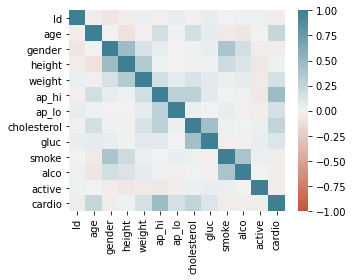

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.heatmap(df.corr(), vmin=-1, vmax=1, 
                 cmap=sns.diverging_palette(20, 220, as_cmap=True),
                 ax=ax)

plt.tight_layout()
plt.show()

The above heatmap works when you have color. For the greyscale images, as used in the book, we need to visualize the direction as well. The following code shows the strength of the correlation using ellipses.

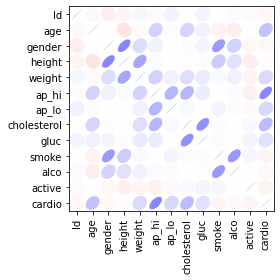

In [ ]:
from matplotlib.collections import EllipseCollection
from matplotlib.colors import Normalize

def plot_corr_ellipses(data, figsize=None, **kwargs):
  
    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')
    fig, ax = plt.subplots(1, 1, figsize=figsize, subplot_kw={'aspect':'equal'})
    ax.set_xlim(-0.5, M.shape[1] - 0.5)
    ax.set_ylim(-0.5, M.shape[0] - 0.5)
    ax.invert_yaxis()

    # xy locations of each ellipse center
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T

    # set the relative sizes of the major/minor axes according to the strength of
    # the positive/negative correlation
    w = np.ones_like(M).ravel() + 0.01
    h = 1 - np.abs(M).ravel() - 0.01
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           norm=Normalize(vmin=-1, vmax=1),
                           transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(ec)

    # if data is a DataFrame, use the row/column names as tick labels
    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index)

    return ec

m = plot_corr_ellipses(df.corr(), figsize=(5, 4), cmap='bwr_r')
cb = fig.colorbar(m)
cb.set_label('Correlation coefficient')

plt.tight_layout()
plt.show()

#Scatterplots
Simple scatterplots are supported by pandas. Specifying the marker as $\u25EF$ uses an open circle for each point.

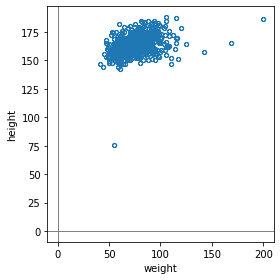

In [ ]:
ax = dfn1.plot.scatter(x='weight', y='height', figsize=(4, 4), marker='$\u25EF$')
ax.set_xlabel('weight')
ax.set_ylabel('height')
ax.axhline(0, color='grey', lw=1)
ax.axvline(0, color='grey', lw=1)

plt.tight_layout()
plt.show()

Line2D(_line1)


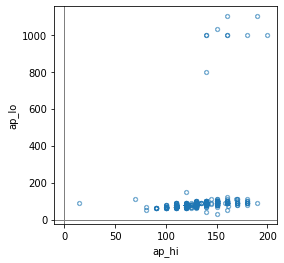

In [ ]:
ax = dfn2.plot.scatter(x='ap_hi', y='ap_lo', figsize=(4, 4), marker='$\u25EF$', alpha=0.5)
ax.set_xlabel('ap_hi')
ax.set_ylabel('ap_lo')
ax.axhline(0, color='grey', lw=1)
print(ax.axvline(0, color='grey', lw=1))

#Hexagonal binning and Contours
Plotting numeric versus numeric data
If the number of data points gets large, scatter plots will no longer be meaningful. Here methods that visualize densities are more useful. The hexbin method for pandas data frames is one powerful approach.

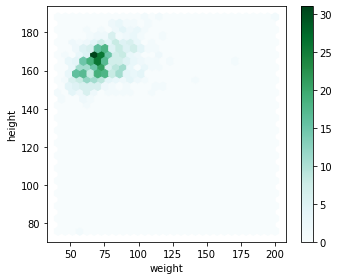

In [ ]:
ax = dfn1.plot.hexbin(x='weight', y='height',
                         gridsize=30, sharex=False, figsize=(5, 4))
ax.set_xlabel('weight')
ax.set_ylabel('height')

plt.tight_layout()
plt.show()

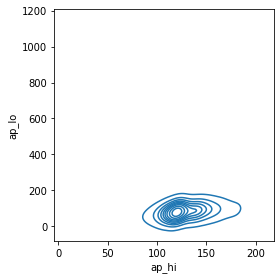

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.kdeplot(data=dfn2, x='ap_hi', y='ap_lo', ax=ax)
ax.set_xlabel('ap_hi')
ax.set_ylabel('ap_lo')

plt.tight_layout()
plt.show()

#Two Categorical Variables
Load the AirQuality dataset

In [ ]:
%cd
from google.colab import drive
drive.mount('/content/gdrive')

/root
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
Location = "/content/gdrive/MyDrive/FDS_PRAC/datasets/FDSJOURNAL_DATASETS/airquality.csv"
df1 = pd.read_csv(Location,index_col=0)
df1.head()

,Ozone,Solar.R,Wind,Temp,Month,Day
1,41.0,190.0,7.4,67,5,1
2,36.0,118.0,8.0,72,5,2
3,12.0,149.0,12.6,74,5,3
4,18.0,313.0,11.5,62,5,4
5,NaN,NaN,14.3,56,5,5


In [ ]:
crosstab = df1.pivot_table(index='Month', columns='Temp', 
                                aggfunc=lambda x: len(x), margins=True)
print(crosstab)

       Day                                               ... Wind            \
Temp    56   57   58   59   61   62   63   64   65   66  ...   88   89   90   
Month                                                    ...                  
5      1.0  3.0  2.0  2.0  3.0  2.0  NaN  1.0  1.0  3.0  ...  NaN  NaN  NaN   
6      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN  ...  NaN  NaN  1.0   
7      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  2.0  1.0  NaN   
8      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  1.0  1.0  2.0   
9      NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  NaN  NaN  ...  NaN  NaN  NaN   
All    NaN  1.0  1.0  2.0  3.0  2.0  1.0  2.0  2.0  2.0  ...  2.0  2.0  3.0   

                                          
Temp    91   92   93   94   96   97  All  
Month                                     
5      NaN  NaN  NaN  NaN  NaN  NaN   24  
6      NaN  1.0  1.0  NaN  NaN  NaN    9  
7      1.0  2.0  NaN  NaN  NaN  NaN   26  
8      NaN  1.0  NaN  2.0  1.0

#Categorical and Numeric Data
Pandas boxplots of a column can be grouped by a different column.

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


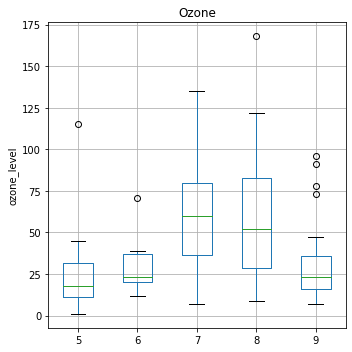

In [ ]:
ax = df1.boxplot(by='Month', column='Ozone',
                           figsize=(5, 5))
ax.set_xlabel('')
ax.set_ylabel('ozone_level')
plt.suptitle('')

plt.tight_layout()
plt.show()

Pandas also supports a variation of boxplots called violinplot.

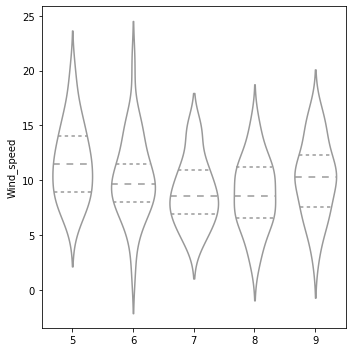

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.violinplot(data=df1, x='Month', y='Wind',
               ax=ax, inner='quartile', color='white')
ax.set_xlabel('')
ax.set_ylabel('Wind_speed')

plt.tight_layout()
plt.show()

**Example 3**

### Import Libraries

Let's import some libraries to get started!

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import trim_mean
from statsmodels import robust
import wquantiles

import seaborn as sns
import matplotlib.pylab as plt

### The Data

Let's start by reading in the diamods.csv file into a pandas dataframe.

In [ ]:
diamonds = pd.read_csv('/content/gdrive/MyDrive/FDS_PRAC/datasets/FDSJOURNAL_DATASETS/_diamond.csv')
diamonds.head()

,id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
diamonds.shape

(53940, 11)

 So, We have 53,940 rows and 10 columns

In [ ]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       53940 non-null  int64  
 1   carat    53940 non-null  float64
 2   cut      53940 non-null  object 
 3   color    53940 non-null  object 
 4   clarity  53940 non-null  object 
 5   depth    53940 non-null  float64
 6   table    53940 non-null  float64
 7   price    53940 non-null  int64  
 8   x        53940 non-null  float64
 9   y        53940 non-null  float64
 10  z        53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


## Data Cleaning and Pre-processing

### Deleting the Index row

In [ ]:
diamonds.drop(['id'] , axis=1 , inplace=True)
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


### Missing Data

In [ ]:
diamonds.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

#### We want to fill in missing numeric data instead of dropping the missing numeric rows. So, we can replace nan values with mean or median in this features.

In [ ]:
diamonds.fillna(value=diamonds[['carat','price']].mean(), inplace=True)

In [ ]:
diamonds.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

#### We can replace nan values with mode because we have very less no.of nan values in categorical columns.

In [ ]:
diamonds['color']= diamonds['color'].fillna(diamonds['color'].mode()[0])
#diamonds['popularity']= diamonds['popularity'].fillna(diamonds['popularity'].mode()[0])

In [ ]:
diamonds.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

Compute the mean, trimmed mean, and median for Price. For mean and median we can use the pandas methods of the data frame. The trimmed mean requires the trim_mean function in scipy.stats.

In [ ]:
print(diamonds['price'].mean())

3932.799721913237


In [ ]:
print(trim_mean(diamonds['price'], 0.1))

3158.9923526140155


In [ ]:
print(diamonds['price'].median())

2401.0


In [ ]:
print(diamonds['carat'].mean())

0.7979397478680014


In [ ]:
print(np.average(diamonds['carat'], weights=diamonds['price']))

1.2410675901587807


In [ ]:
print(wquantiles.median(diamonds['carat'], weights=diamonds['price']))

1.15


## Estimates of Variability

In [ ]:
print(diamonds.head(8))

   carat        cut color clarity  depth  table  price     x     y     z
0   0.23      Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21    Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23       Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29    Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31       Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75
5   0.24  Very Good     J    VVS2   62.8   57.0    336  3.94  3.96  2.48
6   0.24  Very Good     I    VVS1   62.3   57.0    336  3.95  3.98  2.47
7   0.26  Very Good     H     SI1   61.9   55.0    337  4.07  4.11  2.53


Standard deviation

In [ ]:
print(diamonds['price'].std())

3989.439738146379


Interquartile range is calculated as the difference of the 75% and 25% quantile.

In [ ]:
print(diamonds['price'].quantile(0.75) - diamonds['price'].quantile(0.25))

4374.25


Median absolute deviation from the median can be calculated with a method in statsmodels.

In [ ]:
print(robust.scale.mad(diamonds['price']))
print(abs(diamonds['price'] - diamonds['price'].median()).median() / 0.6744897501960817)

2475.9457049043554
2475.9457049043554


## Percentiles and Boxplots

Pandas has the quantile method for data frames.

In [ ]:
print(diamonds['carat'].quantile([0.05, 0.25, 0.5, 0.75, 0.95]))

0.05    0.30
0.25    0.40
0.50    0.70
0.75    1.04
0.95    1.70
Name: carat, dtype: float64


In [ ]:
percentages = [0.05, 0.25, 0.5, 0.75, 0.95]
df = pd.DataFrame(diamonds['carat'].quantile(percentages))
df.index = [f'{p * 100}%' for p in percentages]
print(df.transpose())

       5.0%  25.0%  50.0%  75.0%  95.0%
carat   0.3    0.4    0.7   1.04    1.7


## Correlation

In [ ]:
diamonds.corr()

,carat,depth,table,price,x,y,z
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


### EXPLORATORY DATA ANALYSIS

Lets begin with some exploratory data analysis!

## Histogram

Text(0.5, 0, 'Prices')

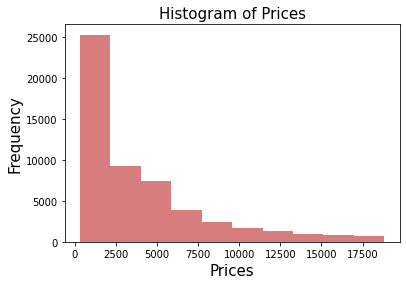

In [ ]:
plt.figure()
plt.hist(x = "price", data = diamonds, color = "indianred", alpha = 0.8)
plt.title("Histogram of Prices", fontsize = 15)
plt.ylabel("Frequency", fontsize = 15)
plt.xlabel("Prices", fontsize = 15)

From the above graph, the distribution of prices is skewed to the right i.e as the prices increase, the number of diamonds decrease. We can carry out a skewness test using scipy's stats module to verify this.

## Countplot

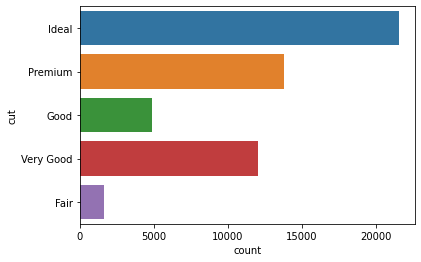

In [ ]:
sns.countplot(y = diamonds.cut)
plt.show()

We have a lot of diamonds of ideal and premium cut quality.

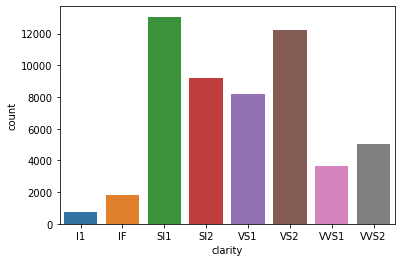

In [ ]:
column_order = sorted(diamonds.clarity.unique())
sns.countplot(x="clarity", data = diamonds.sort_values(["price", "depth"]), order = column_order)

## Heatmap

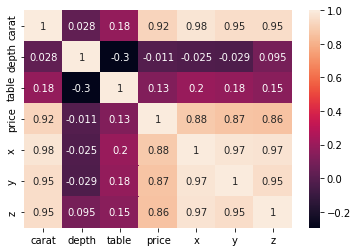

In [ ]:
sns.heatmap(data = diamonds.corr(), annot = True)

we can use them to decide which features are more highly correlated.

## Categorical and Numeric Data

Pandas boxplots of a column can be grouped by a different column.
Can't run this program.(popularity)

Text(0, 0.5, 'price')

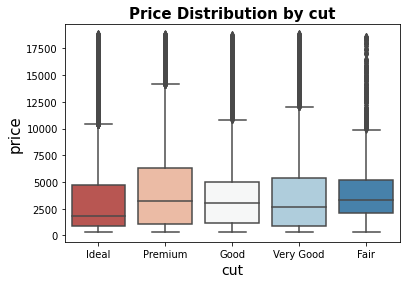

In [ ]:
sns.boxplot(x="cut", y="price", data = diamonds, palette = "RdBu")
plt.title("Price Distribution by cut", fontsize = 15, fontweight = "bold")
plt.xlabel("cut",size=14)
plt.ylabel("price", size = 15)

**Example 4**

In [ ]:
#Import all required packages:
import warnings
warnings.filterwarnings("ignore")
import os
import itertools
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 5

There are several categories in the Superstore sales data, I start from time series analysis and forecasting for Technology sales.

We have a good 4-year furniture sales data.

In [ ]:
location=("/content/gdrive/MyDrive/FDS_PRAC/datasets/FDSJOURNAL_DATASETS/Sample - Superstore.xls - Orders.csv")
data_original = pd.read_csv(location)
data_original.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [ ]:
data_original.shape

(9994, 21)

In [ ]:
# categories of sales data
data_original.Category.value_counts()

Office Supplies    6026
Furniture          2121
Technology         1847
Name: Category, dtype: int64

In [ ]:
# copy only the rows related to category = Technology
Technology = data_original.loc[data_original['Category'] == 'Technology']
Technology.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
7,8,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,907.152,6,0.2,90.7152
11,12,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,TEC-PH-10002033,Technology,Phones,Konftel 250 Conference phone - Charcoal black,911.424,4,0.2,68.3568
19,20,CA-2014-143336,8/27/2014,9/1/2014,Second Class,ZD-21925,Zuschuss Donatelli,Consumer,United States,San Francisco,...,94109,West,TEC-PH-10001949,Technology,Phones,Cisco SPA 501G IP Phone,213.480,3,0.2,16.0110
26,27,CA-2016-121755,1/16/2016,1/20/2016,Second Class,EH-13945,Eric Hoffmann,Consumer,United States,Los Angeles,...,90049,West,TEC-AC-10003027,Technology,Accessories,Imation 8GB Mini TravelDrive USB 2.0 Flash Drive,90.570,3,0.0,11.7741
35,36,CA-2016-117590,12/8/2016,12/10/2016,First Class,GH-14485,Gene Hale,Corporate,United States,Richardson,...,75080,Central,TEC-PH-10004977,Technology,Phones,GE 30524EE4,1097.544,7,0.2,123.4737


In [ ]:
# data_original range
Technology['Order Date'].min(), Technology['Order Date'].max()

('1/10/2016', '9/9/2017')

# **Data Exploration:**
This step includes removing columns we do not need, check missing values, aggregate sales by date and so on

In [ ]:
Technology.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [ ]:
# columns to drop
cols = ['Row ID', 
        'Order ID', 
        'Ship Date', 
        'Ship Mode', 
        'Customer ID', 
        'Customer Name', 
        'Segment', 
        'Country', 
        'City', 
        'State', 
        'Postal Code', 
        'Region', 
        'Product ID', 
        'Category', 
        'Sub-Category', 
        'Product Name', 
        'Quantity', 
        'Discount', 
        'Profit']

Technology.drop(cols, axis=1, inplace=True)

In [ ]:
Technology.sort_values('Order Date', inplace=True)
# check for null values
Technology.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [ ]:
Technology.columns
# Lets check if we have more than one sales data for a date:
temp = Technology.groupby('Order Date')['Sales'].size() 
temp[temp > 1].sort_values(ascending=False)

Order Date
9/24/2017     10
7/3/2017       9
11/12/2017     8
11/24/2016     8
11/13/2017     8
              ..
6/11/2016      2
6/12/2016      2
6/12/2017      2
6/13/2015      2
5/30/2017      2
Name: Sales, Length: 473, dtype: int64

In [ ]:
# aggregate sales by date
Technology = Technology.groupby('Order Date')['Sales'].sum().reset_index()
# Indexing with Time Series Data
Technology = Technology.set_index('Order Date')
print(Technology.index)
print(Technology.sample(10))

Index(['1/10/2016', '1/11/2016', '1/12/2015', '1/13/2014', '1/14/2017',
       '1/15/2014', '1/15/2016', '1/15/2017', '1/16/2014', '1/16/2016',
       ...
       '9/6/2015', '9/6/2016', '9/7/2014', '9/7/2015', '9/7/2017', '9/8/2014',
       '9/8/2016', '9/8/2017', '9/9/2014', '9/9/2017'],
      dtype='object', name='Order Date', length=824)
               Sales
Order Date          
6/1/2017     282.236
7/16/2015    599.900
8/21/2017    465.148
4/2/2014    1049.930
12/21/2015  1436.426
12/29/2017   302.376
7/30/2017     89.950
6/20/2016    169.668
1/31/2016    109.592
8/23/2015    251.910


<Figure size 1152x432 with 0 Axes>

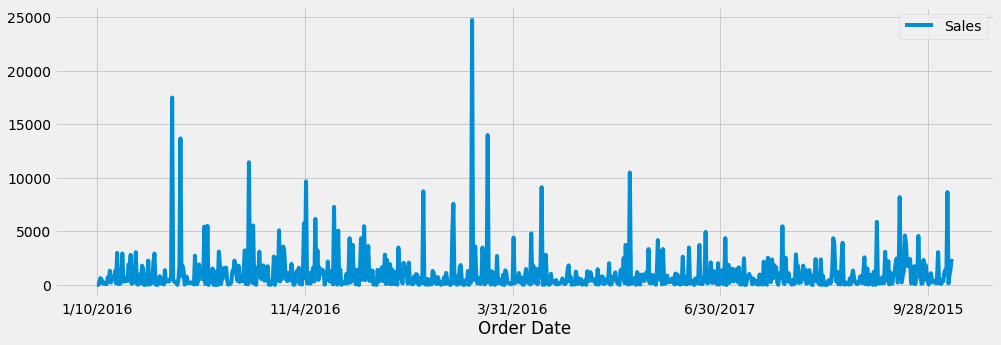

In [ ]:
plt.figure(figsize=(16, 6));
Technology.plot();

DatetimeIndex can be used for the individual date/time components are all available as attributes such as year, month, day, and so on.

In [ ]:
# Add columns with year, month, and weekday name
Technology['Year']         = pd.DatetimeIndex(Technology.index).year
Technology['Month']        = pd.DatetimeIndex(Technology.index).month

# Display a random sampling of 5 rows
Technology.sample(10, random_state=0)

,Sales,Year,Month
Order Date,,,
10/25/2015,158.990,2015,10
1/28/2017,689.880,2017,1
1/16/2014,124.200,2014,1
2/20/2014,62.310,2014,2
9/8/2016,152.712,2016,9
9/13/2015,199.960,2015,9
8/20/2016,14.780,2016,8
12/5/2014,793.390,2014,12
3/17/2015,15.020,2015,3


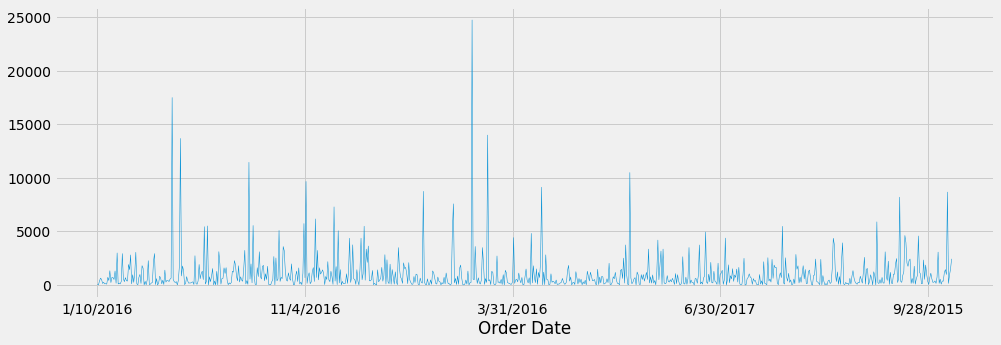

In [ ]:
# create a line plot of the full time series of daily sales, 
# using the DataFrame’s plot() method.
Technology['Sales'].plot(linewidth=0.5);

# **Checking for seasonality**

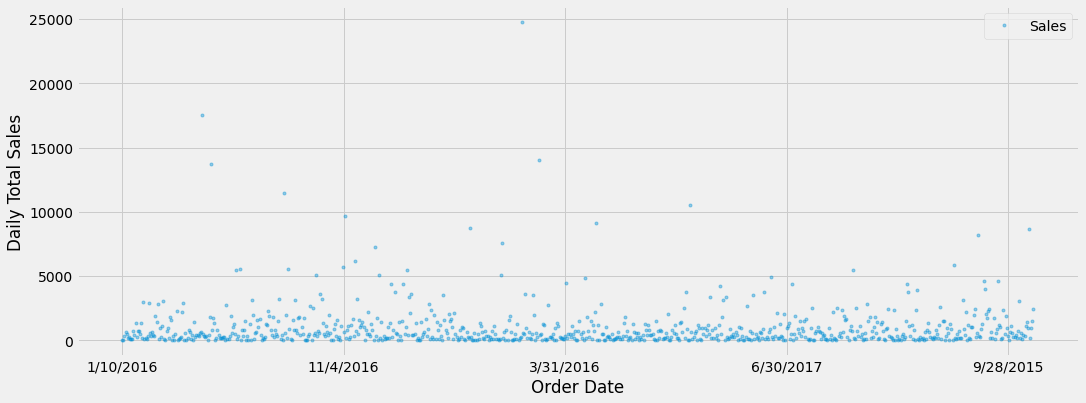

In [ ]:
# Use seaborn style defaults and set the default figure size
# sns.set(rc={'figure.figsize':(18, 6)})

cols_plot = ['Sales']

axes      = Technology[cols_plot].plot(marker='.',
                                       alpha=0.4, 
                                       linestyle='None', 
                                       figsize=(16, 6), 
                                       subplots=True)

for ax in axes:
    ax.set_ylabel('Daily Total Sales')

**Checking Seasonality using Box-Plots:**

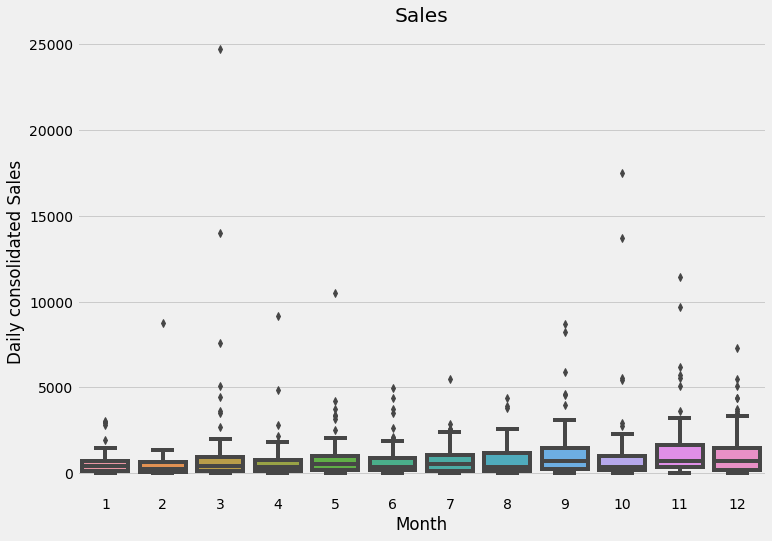

In [ ]:
fig, ax = plt.subplots(figsize=(11, 8))

sns.boxplot(data=Technology, x='Month', y='Sales', ax=ax)

ax.set_title('Sales')

ax.set_ylabel('Daily consolidated Sales');

Now we try to plot the graph by the year starting from 2014 to 2017

In [ ]:
cols_plot = ['Sales']

Technology.loc['2014'][cols_plot].plot(linewidth=0.5);
Technology.loc['2015'][cols_plot].plot(linewidth=0.5);
Technology.loc['2016'][cols_plot].plot(linewidth=0.5);
Technology.loc['2017'][cols_plot].plot(linewidth=0.5);

KeyError: ignored

**observation:**

1.the trend, seasonality is not obvious from the above plots, as there are a lots of data points.

2.There seems to indication of seasonality at the end of the year 2015 and 2017, but we can not see the certain seasonality.

3.we can roll-up the data, weekly & monthly and then re-plot

# **sales - Monthly resampling**

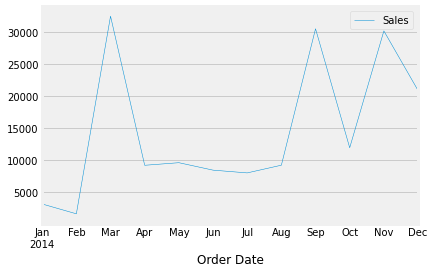

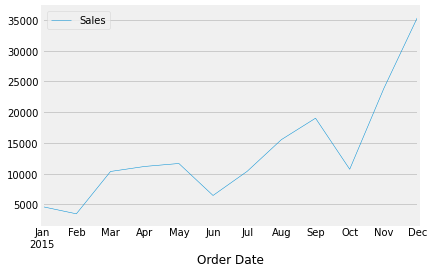

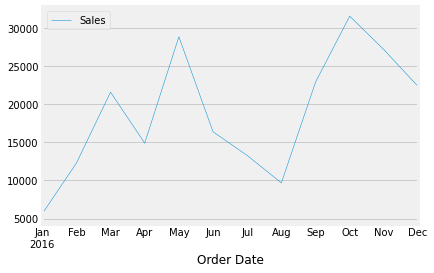

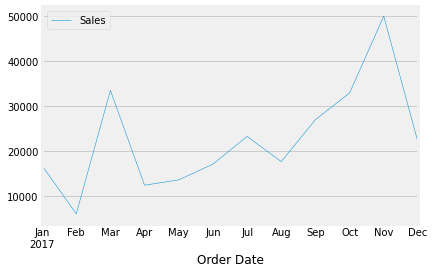

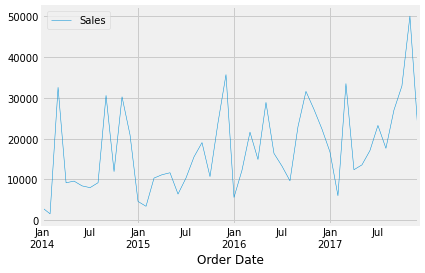

In [ ]:
# monthly sales
data_columns = ['Sales']

# Resample to weekly frequency, aggregating with mean
Technology_monthly = Technology[data_columns].resample('M').sum()
Technology_monthly.head(3)

cols_plot = ['Sales']

Technology_monthly.loc['2014'][cols_plot].plot(linewidth=0.5);
Technology_monthly.loc['2015'][cols_plot].plot(linewidth=0.5);
Technology_monthly.loc['2016'][cols_plot].plot(linewidth=0.5);
Technology_monthly.loc['2017'][cols_plot].plot(linewidth=0.5);
Technology_monthly[cols_plot].plot(linewidth=0.5);

**observation**

1.Every year, there is slight uptrend visible

2.sales up in the months of Sep-Oct-Nov

3.Consolidated 4 years - slight uptrend in sales numbers

4.sales picks up in the last QTR of every calender year(Except December), indicates seasonality

# **Stationary test**
1.Data points are often non-stationary or have means, variances and covariances that change over time.

2.Non-stationary behaviors can be trends, cycles, random walks or combinations of the three.

3.Non-stationary data, as a rule, are unpredictable and cannot be modeled or forecasted.



Stationarity test : Method 1 : Plots

In [ ]:
Technology_monthly['Sales'].plot();

NameError: ignored

Stationarity test : Method 2 : Summary Statistics

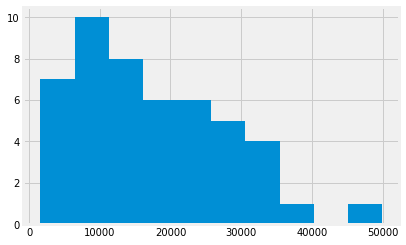

In [ ]:
Technology_monthly['Sales'].hist();

In [ ]:
X = Technology_monthly['Sales'].values
split = len(X) / 2
split = int(split)

X1, X2 = X[0:split], X[split:]

mean1, mean2 = X1.mean(), X2.mean()
var1,  var2  = X1.var(),  X2.var()

print('mean1     = {:10.2f}, mean2     = {:10.2f}'.format(mean1, mean2))
print('variance1 = {:10.2f}, variance2 = {:10.2f}'.format(var1,  var2))

mean1     =   14085.79, mean2     =   20753.96
variance1 = 93096702.63, variance2 = 97720479.23


-the mean and variance values are different. But in the same ball-park range.

-Hence the time series is stationary